<img style="float: left;padding: 1.3em" src="https://indico.in2p3.fr/event/18313/logo-786578160.png">  

#  Gravitational Wave Open Data Workshop #2


#### Tutorial 2.5:  Parameter estimation for compact object mergers -- Using and interpreting posterior samples

This is a simple demonstration to loading and viewing data released in associaton with the publication titled __Observations of Compact Binary Mergers by Advanced LIGO and Advanced Virgo during the First and Second Observing Runs__ avaliable through [DCC](https://dcc.ligo.org/LIGO-P1800307/public) and [arXiv](https://arxiv.org/). This should lead to discussion and interpretation.

The data used in these tutorials will be downloaded from the public DCC page [LIGO-P1800370](https://dcc.ligo.org/LIGO-P1800370/public).

[Click this link to view this tutorial in Google Colaboratory](https://colab.research.google.com/github/gw-odw/odw-2019/blob/master/Day_2/Tuto_2.5_Parameter_estimation_for_compact_object_mergers.ipynb)

## Installation (execute only if running on a cloud platform!)¶

In [1]:
# -- Use the following line for google colab
#! pip install -q 'corner==2.0.1'

**Important**: With Google Colab, you may need to restart the runtime after running the cell above.

## Initialization

In [2]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd
import corner
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import optimize

## Get the data

Selecting the event, let's pick GW150914.

In [3]:
label = 'GW150914'

# if you do not have wget installed, simply download manually 
# https://dcc.ligo.org/LIGO-P1800370/public/GW150914_GWTC-1.hdf5 
# from your browser
#! wget https://dcc.ligo.org/LIGO-P1800370/public/{label}_GWTC-1.hdf5

In [4]:
posterior_file = './'+label+'_GWTC-1.hdf5'
posterior = h5py.File(posterior_file, 'r')

### Looking into the file structure

In [5]:
print('This file contains four datasets: ',posterior.keys())

This file contains four datasets:  <KeysViewHDF5 ['IMRPhenomPv2_posterior', 'Overall_posterior', 'SEOBNRv3_posterior', 'prior']>


This data file contains several datasets, two using separate models for the gravitaional waveform (`IMRPhenomPv2` and `SEOBNRv3` respectively, see the [paper](https://dcc.ligo.org/LIGO-P1800307) for more details). 

It also contiains a joint dataset, combining equal numbers of samples from each individual model, these datasets are what is shown in the [paper](https://dcc.ligo.org/LIGO-P1800307). 

Finally, there is a dataset containing samples drawn from the prior used for the analyses.

In [6]:
print(posterior['Overall_posterior'].dtype.names)

('costheta_jn', 'luminosity_distance_Mpc', 'right_ascension', 'declination', 'm1_detector_frame_Msun', 'm2_detector_frame_Msun', 'spin1', 'spin2', 'costilt1', 'costilt2')


Here are some brief descriptions of these parameters and their uses:

 * `luminosity_distance_Mpc`: luminosity distance [Mpc]

 * `m1_detector_frame_Msun`: primary (larger) black hole mass (detector frame) [solar mass]

 * `m2_detector_frame_Msun`: secondary (smaller) black hole mass (detector frame) [solar mass]

 * `right_ascension`, `declination`: right ascension and declination of the source [rad].

 * `costheta_jn`: cosine of the angle between line of sight and total angular momentum vector of system.

 * `spin1`, `costilt1`: primary (larger) black hole spin magnitude (dimensionless) and cosine of the zenith angle between the spin and the orbital angular momentum vector of system.

 * `spin2`, `costilt2`: secondary (smaller) black hole spin magnitude (dimensionless) and cosine of the zenith angle between the spin and the orbital angular momentum vector of system.

A convenient (and pretty) way to load up this array of samples is to use [pandas](https://pandas.pydata.org/):

In [7]:
samples=pd.DataFrame.from_records(np.array(posterior['Overall_posterior']))

In [8]:
samples

,costheta_jn,luminosity_distance_Mpc,right_ascension,declination,m1_detector_frame_Msun,m2_detector_frame_Msun,spin1,spin2,costilt1,costilt2
0,-0.976633,517.176717,1.456176,-1.257815,39.037380,37.044563,0.417147,0.867740,-0.280624,0.403853
1,-0.700404,401.626864,2.658802,-0.874661,34.620096,34.184416,0.125709,0.260679,-0.757349,-0.312285
2,-0.840752,369.579071,1.106548,-1.136396,37.894343,33.970520,0.581047,0.926893,0.649781,-0.510843
3,-0.583657,386.935268,2.077180,-1.246351,36.412973,35.684463,0.235808,0.094391,0.116578,-0.720505
4,-0.928271,345.104345,0.993604,-1.069243,39.477251,31.645008,0.511521,0.868009,-0.438237,0.269333
...,...,...,...,...,...,...,...,...,...,...
8345,-0.691637,306.985025,1.485646,-1.269228,37.561962,33.355792,0.484003,0.627191,0.194507,-0.408345
8346,-0.834615,462.649414,2.065362,-1.265618,37.824298,36.674075,0.589654,0.650758,-0.737792,0.875384
8347,-0.911463,448.930876,1.536913,-1.257956,38.063291,35.757913,0.708407,0.714805,0.852085,-0.797475
8348,-0.856914,561.020036,2.367289,-1.211824,44.884396,31.592433,0.389284,0.521304,-0.251461,0.830526


# Chirp Mass

In [9]:
samples = np.asarray(samples)
m1 = samples[0:8350,4]
m2 = samples[0:8350,5]
Mc = (m1*m2)**(3/5)/(m1 + m2)**(1/5)
lower_bound = np.quantile(Mc, 0.05)
upper_bound = np.quantile(Mc, 0.95)
median = np.quantile(Mc, 0.5)
print("Mc = {} with a 90% C.I = {} -> {}".format(median, lower_bound, upper_bound))

Mc = 31.23055308109465 with a 90% C.I = 29.655877108464615 -> 32.97324559242388


In [10]:
def Gaussian(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2.0/(2.0*sigma**2.0))

Mc_hist = np.linspace(min(Mc),max(Mc),50)*0
bins = np.linspace(min(Mc),max(Mc),51)

for i in range(len(bins)):
    for j in range(len(Mc)):
        if bins[i] < Mc[j] < bins[i+1]:
            Mc_hist[i] += 1
    

start_vals = np.array([10, 31.2, 1.00]) #initial guess
param_dict=['a','x0','sigma']
plotx = np.linspace(min(Mc),max(Mc),50)
popt,pcov = optimize.curve_fit(Gaussian,xdata=plotx,ydata=Mc_hist,p0=start_vals,maxfev=100000000)

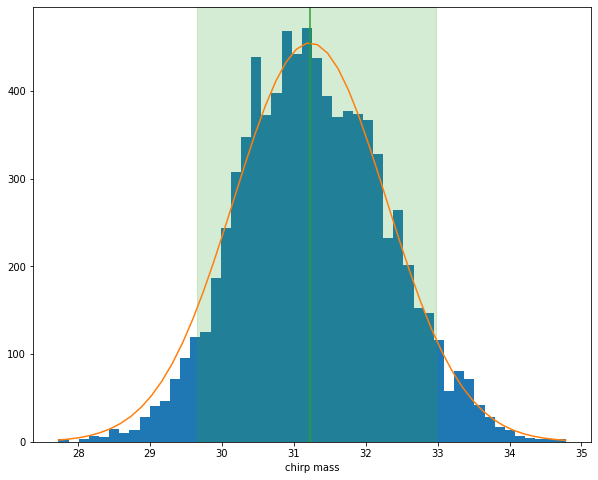

In [11]:
plt.figure(figsize = (10,8))
plt.hist(Mc, bins=50)
plt.axvspan(lower_bound, upper_bound, color='C2', alpha=0.2)
plt.plot(plotx,Gaussian(plotx,*popt), label = "fit result")
plt.axvline(median, color='C2')
plt.xlabel("chirp mass")
plt.show()

# For Landon
## Can you calculate the total mass and see if you get a Gaussian distribution for the total mass.

In [12]:
#your code goes here

## After you get the mass, you can go back to 2.2 (GW150914) and get the frequency information then calculate the velocity 
$v = (GM\pi f)^{1/3}$

In [13]:
#your code goes here

# Luminosity Distance

Mc = 1.6768742520431272 with a 90% C.I = 0.9449076957563968 -> 2.5470574177196803


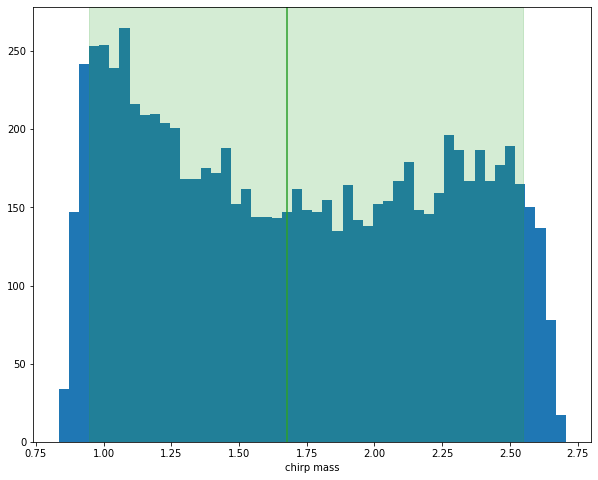

In [14]:
samples = np.asarray(samples)
LD = samples[0:8350,2]
lower_bound = np.quantile(LD, 0.05)
upper_bound = np.quantile(LD, 0.95)
median = np.quantile(LD, 0.5)
print("Mc = {} with a 90% C.I = {} -> {}".format(median, lower_bound, upper_bound))

plt.figure(figsize = (10,8))
plt.hist(LD, bins=50)
plt.axvspan(lower_bound, upper_bound, color='C2', alpha=0.2)
plt.axvline(median, color='C2')
plt.xlabel("chirp mass")
plt.show()

Those are all the samples stored in the `Overall` dataset. 

### Plotting

We can plot all of them with, for instance, the [corner](https://corner.readthedocs.io/en/latest/) package:

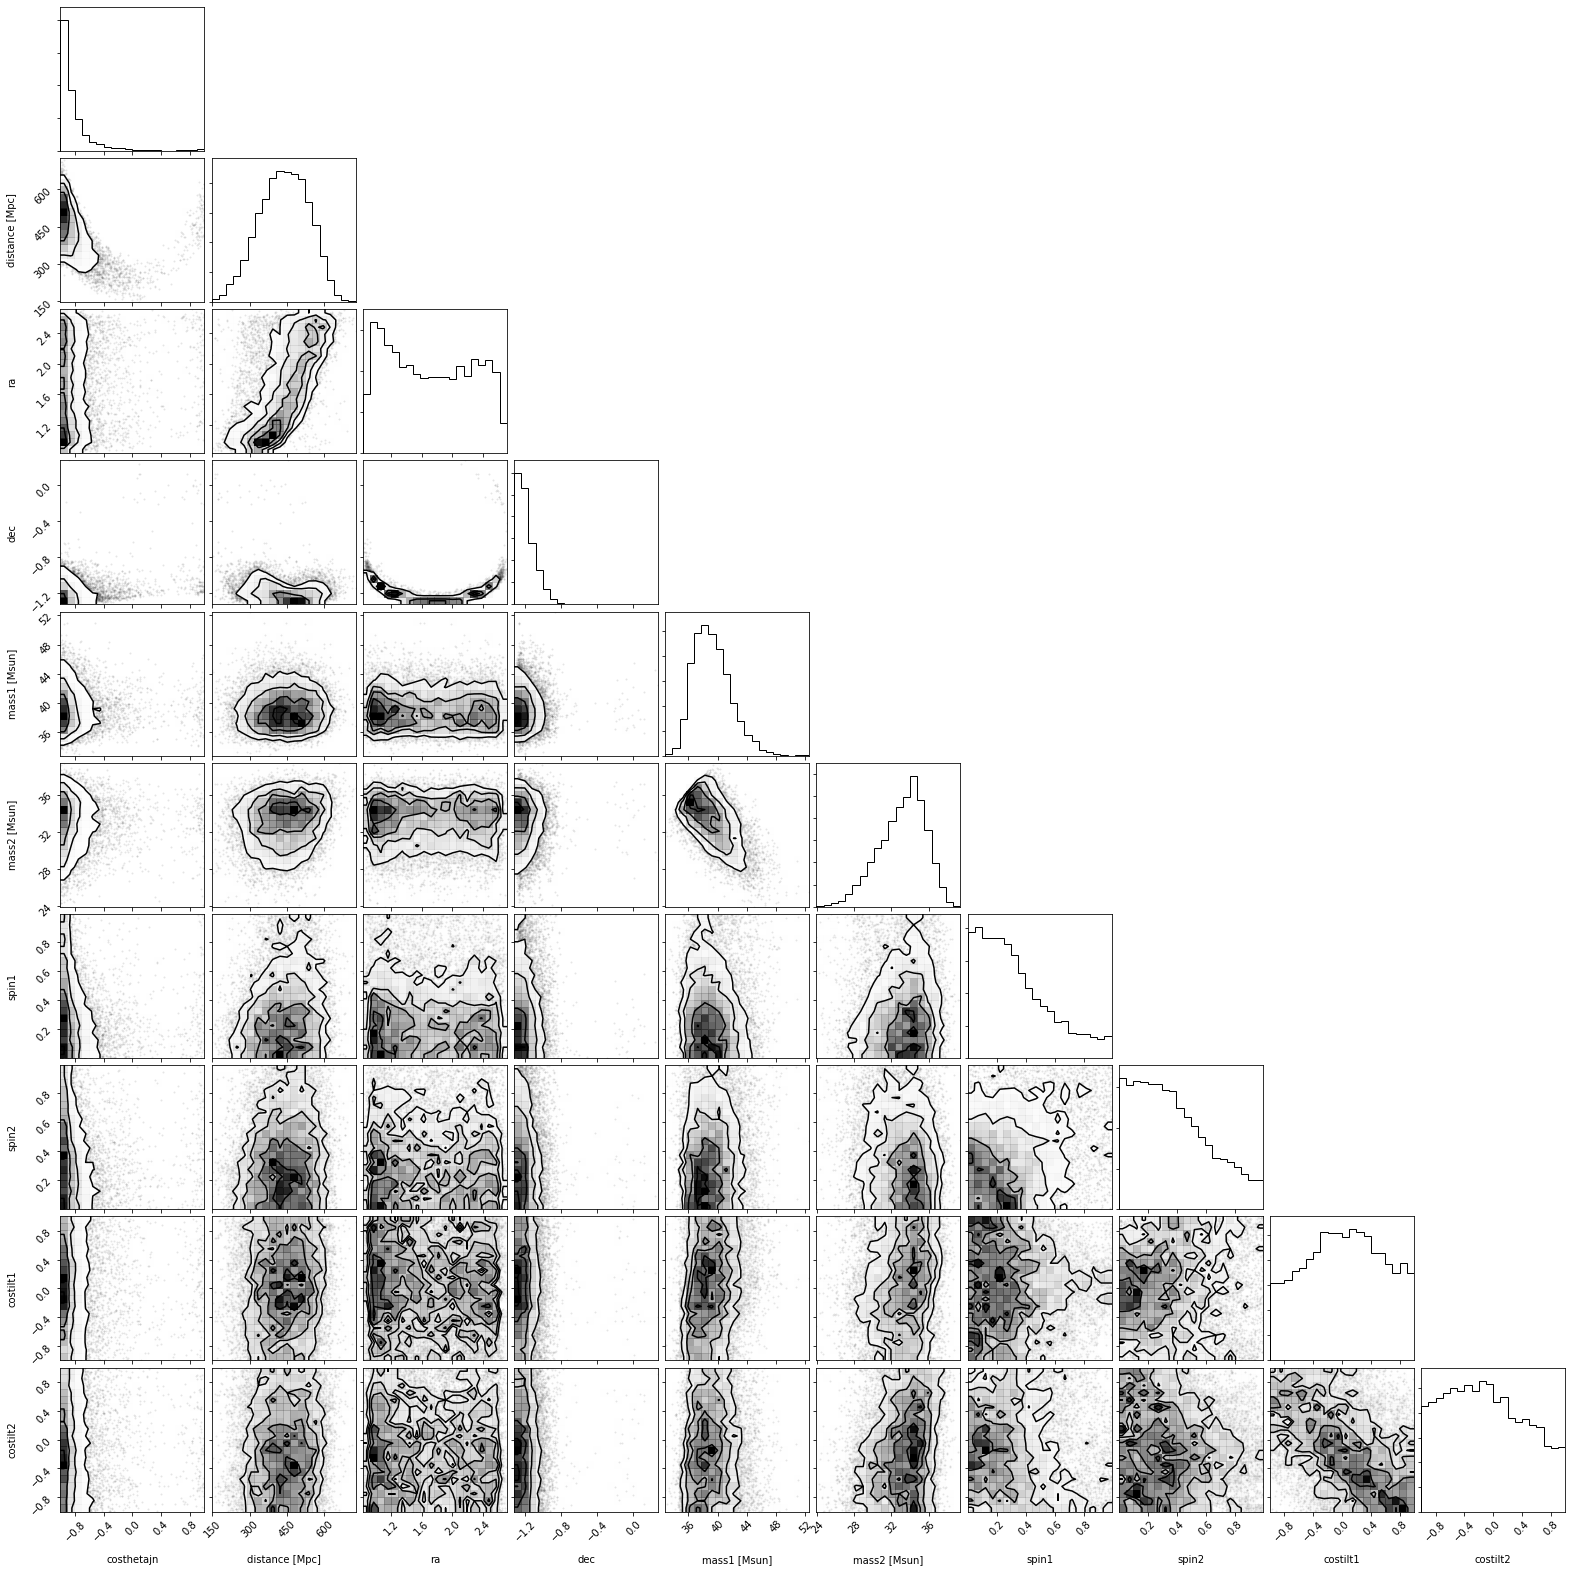

In [15]:
corner.corner(samples,labels=['costhetajn',
                                'distance [Mpc]',
                                'ra',
                                'dec',
                                'mass1 [Msun]',
                                'mass2 [Msun]',
                                'spin1',
                                'spin2',
                                'costilt1',
                                'costilt2']);

Each one and two dimentional histogram are *marginalised* probabilby density functions. We can manualy select one parameter, say `luminosity distance`, and plot the four different marginalised distributions:

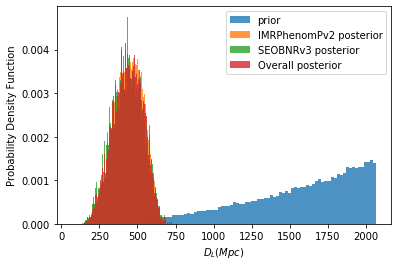

In [16]:
plt.hist(posterior['prior']['luminosity_distance_Mpc'], bins = 100, label='prior', alpha=0.8, density=True)
plt.hist(posterior['IMRPhenomPv2_posterior']['luminosity_distance_Mpc'], bins = 100, label='IMRPhenomPv2 posterior', alpha=0.8, density=True)
plt.hist(posterior['SEOBNRv3_posterior']['luminosity_distance_Mpc'], bins = 100, label='SEOBNRv3 posterior', alpha=0.8, density=True)
plt.hist(posterior['Overall_posterior']['luminosity_distance_Mpc'], bins = 100, label='Overall posterior', alpha=0.8, density=True)
plt.xlabel(r'$D_L (Mpc)$')
plt.ylabel('Probability Density Function')
plt.legend()
plt.show()

### Computing new quantities

The masses given are the ones seens by the detector, in the "detector frame". To get the masses of the source black holes, we need to correct for the gravitational-wave redshifting. This forces us to assume a cosmology:

In [17]:
import astropy.units as u
from astropy.cosmology import Planck15, z_at_value

We now compute the redshift value for all the samples (using only their distance value). See [astropy.cosmology](http://docs.astropy.org/en/stable/api/astropy.cosmology.z_at_value.html) for implementation details, in particular how to make the following more efficient:

In [18]:
z = np.array([z_at_value(Planck15.luminosity_distance, dist * u.Mpc) for dist in samples['luminosity_distance_Mpc']])

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
samples['m1_source_frame_Msun']=samples['m1_detector_frame_Msun']/(1.0+z)
samples['m2_source_frame_Msun']=samples['m2_detector_frame_Msun']/(1.0+z)
samples['redshift']=z

And we can plot the marginalised probability density functions:

In [ ]:
corner.corner(samples[['m1_source_frame_Msun','m2_source_frame_Msun','redshift']],labels=['m1 (source)',
                                                                                          'm2 (source)',
                                                                                          'z']);

By the way, what's the prior in the redshift?

In [ ]:
prior=pd.DataFrame.from_records(np.array(posterior['prior']))
z = np.array([z_at_value(Planck15.luminosity_distance, dist * u.Mpc) for dist in prior['luminosity_distance_Mpc']])
plt.hist(z, bins = 100, label='prior', alpha=0.8, density=True)
plt.xlabel(r'$z$')
plt.ylabel('Probability Density Function')
plt.show()